In [96]:
import os
from os.path import isfile, join
import pandas as pd
import seaborn as sns

In [75]:
OUTPUT_DIR = 'out'
reports = [f for f in os.listdir(OUTPUT_DIR) if isfile(join(OUTPUT_DIR, f)) and f[0] != '.']
reports

['windows-ns3Da-python-2.txt',
 'linux-GT01R-python-1.txt',
 'windows-ns3Da-python-1.txt',
 'linux-GT01R-python-2.txt',
 'linux-GT01R-octave-2.txt',
 'windows-ns3Da-octave-1.txt',
 'linux-GT01R-octave-1.txt',
 'windows-ns3Da-octave-2.txt',
 'linux-TSC_OPF_1047-octave-2.txt',
 'linux-TSC_OPF_1047-octave-1.txt',
 'linux-TSC_OPF_1047-python-1.txt',
 'linux-TSC_OPF_1047-python-2.txt',
 'windows-TSC_OPF_1047-octave-2.txt',
 'windows-TSC_OPF_1047-octave-1.txt',
 'windows-TSC_OPF_1047-python-1.txt',
 'windows-TSC_OPF_1047-python-2.txt',
 'windows-GT01R-octave-1.txt',
 'linux-ns3Da-octave-2.txt',
 'windows-GT01R-octave-2.txt',
 'linux-ns3Da-octave-1.txt',
 'linux-ns3Da-python-1.txt',
 'windows-GT01R-python-2.txt',
 'linux-ns3Da-python-2.txt',
 'windows-GT01R-python-1.txt']

In [113]:
HEADER = {'matrix': str, 'os': str, 'script': str, 'run': int,
          'size': int, 'nnz': int, 'error': float, 'time': float,
          'mem_peak': float, 'mem_avg': float}
data = []
for report in reports:
    with open(join(OUTPUT_DIR, report), 'r') as f:
        new_line = []
        metadata = report.split('.')[0].split('-')
        new_line += [metadata[1], metadata[0], metadata[2], metadata[3]]
        new_line += f.readline().split(';')
        data.append(new_line)
df = pd.DataFrame(data=data, columns=HEADER.keys())
df = df.sort_values(by=["matrix", "os", "script", "run"], ignore_index=True)
df = df.astype(HEADER)
df

,matrix,os,script,run,size,nnz,error,time,mem_peak,mem_avg
0,GT01R,linux,octave,1,63680400,430909,4.430250e-15,0.715639,238576.0,0.0
1,GT01R,linux,octave,2,63680400,430909,4.430250e-15,0.772768,223000.0,0.0
2,GT01R,linux,python,1,7980,430909,8.200859e-13,1.258672,130228.0,0.0
3,GT01R,linux,python,2,7980,430909,8.200859e-13,1.307804,129996.0,0.0
4,GT01R,windows,octave,1,63680400,430909,4.430250e-15,0.715639,238576.0,0.0
5,GT01R,windows,octave,2,63680400,430909,4.430250e-15,0.772768,223000.0,0.0
6,GT01R,windows,python,1,7980,430909,8.200859e-13,1.258672,130228.0,0.0
7,GT01R,windows,python,2,7980,430909,8.200859e-13,1.307804,129996.0,0.0
8,TSC_OPF_1047,linux,octave,1,66259600,2012833,5.071850e-12,1.047590,345016.0,0.0
9,TSC_OPF_1047,linux,octave,2,66259600,2012833,5.071850e-12,1.036870,344904.0,0.0


In [114]:
# Dimensione matrici

Text(0.5, 1.0, 'Matrix dimension')

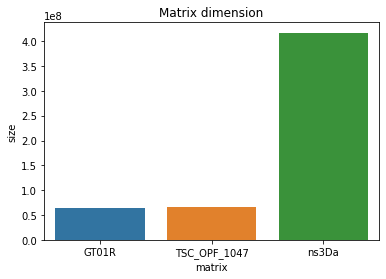

In [115]:
sns.barplot(data=df.groupby("matrix").max().reset_index(), x="matrix", y="size").set_title("Matrix dimension")

Text(0.5, 1.0, 'Non zero elements')

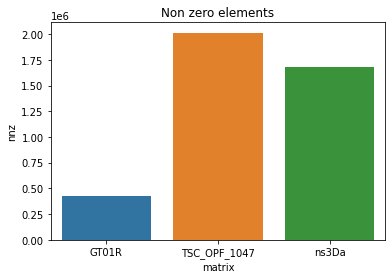

In [116]:
sns.barplot(data=df.groupby("matrix").max().reset_index(), x="matrix", y="nnz").set_title("Non zero elements")

